In [1]:
!pip install kagglehub

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("yingwurenjian/chicago-divvy-bicycle-sharing-data")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/yingwurenjian/chicago-divvy-bicycle-sharing-data/versions/1


In [3]:
import pandas as pd
df = pd.read_csv(path+"/data.csv", nrows=1_000_000)

In [4]:
# =========================
# Reproducibility Settings
# =========================

import os
import random
import numpy as np
import torch

SEED = 42

# Python random
random.seed(SEED)

# NumPy random
np.random.seed(SEED)

# PyTorch CPU
torch.manual_seed(SEED)

# PyTorch GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# CUDA determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Seeds set for reproducibility.")

Seeds set for reproducibility.


In [5]:
from sklearn.model_selection import train_test_split

df, df_final_holdout = train_test_split(df, test_size=0.5, random_state=42)

In [6]:
df_final_holdout = df_final_holdout.reset_index()

In [7]:
df = df.reset_index()
x = df.drop(columns = ['tripduration'])
y = df['tripduration']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=1/3, random_state=42
)


In [9]:
x_train = x_train.reset_index()
# this the data that will be used to train the data 


In [10]:
x_test = x_test.reset_index()

## 1.2 Feature Engineering 

To start off our feature engineering we are going to drop the columns trip_id, starttime, and stoptime from the list of predictors. We will drop starttime because the same information is captured in year, month, week, day and hour columns. We will drop stoptime variable to ensure that our model is not simply just using starttime (year/month/week/day/hour) and stoptime to calculate tripduration. We will drop trip_id because it is a unique identifier for database not a true predictor. 

In [11]:
x_train = x_train.drop(columns = ['trip_id','starttime','stoptime'])
x_test = x_test.drop(columns =['trip_id','starttime','stoptime'])

In the following we will create the following features: 
- `distance_km`: distance measured by using Manhattan distance  
- `from_station_idx`: (embedding) captures station-specific congestion, elevation, neighborhood density, and typical trip behavior 
- `to_station_idx`: (embedding) captures destination-area characteristics affectign arrival congestion and travel patterns 
- `hour_sin`,`hour_cos`: Encodes time-of-day traffic patterns. Rush hour congestion directly impacts duration 
- `is_rush_hour`: Directly models peak traffic consitions 
- `is_weekend`: Weekends trips are often recreational and longer in duration 
- `delta_lat`,`delta_lon`: Encodes direction of travel; some routes may systematically take longer due to layout 
- `temperature`/`temp_squared`: Weather affects rider speed and trip behavior 
- `capacity_diff`,`capacity_ratio`: Proxy for station size and potential congestion differences 
- `month_sin`,`month_cos`: Seasonal effects (tourism, daylight, weather trends) 
- `same_station`: Edge case trips starting and ending at same location 
- `is_cold`,`is_hot`: extreme weather behavior indicators
- `gender`: Usually a weak predictor of trip duration 
- `usertype`: Moderate effect (subscribers often shorter commute trips)
- `events`: weather 
In the following block of code we implement a function that takes in the datafram enad makes the new features from the original features. 

In [13]:
# converts start lattitude and longitude to Manhattan distance  
# a function that outputs the manhattan distance for two points 
# the following would be our spatial features 
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def manhattan_distance(lat1, lon1, lat2, lon2):
    # Convert degree differences
    dlat = np.abs(lat1 - lat2)
    dlon = np.abs(lon1 - lon2)
    
    # Convert to kilometers
    lat_km = dlat * 111
    lon_km = dlon * 111 * np.cos(np.radians((lat1 + lat2) / 2))
    
    return lat_km + lon_km

# -------------------------------------------------
# TRAIN PREPROCESSING
# -------------------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder





def preprocess_trip_data(
    X,
    y=None,
    fit=True,
    scaler=None,
    encoder=None,
    station_to_idx=None
):

    X = X.copy()

    # -------------------------------------------------
    # 1️⃣ Drop irrelevant columns
    # -------------------------------------------------
    drop_cols = [
        "level_0",
        "index",
        "from_station_name",
        "to_station_name"
    ]
    X = X.drop(columns=[c for c in drop_cols if c in X.columns])

    # -------------------------------------------------
    # 2️⃣ Distance & Direction
    # -------------------------------------------------
    X["distance_km"] = manhattan_distance(
        X["latitude_start"],
        X["longitude_start"],
        X["latitude_end"],
        X["longitude_end"]
    )

    X["delta_lat"] = X["latitude_end"] - X["latitude_start"]
    X["delta_lon"] = X["longitude_end"] - X["longitude_start"]

    # -------------------------------------------------
    # 3️⃣ Capacity Features
    # -------------------------------------------------
    X["capacity_diff"] = X["dpcapacity_end"] - X["dpcapacity_start"]
    X["capacity_ratio"] = X["dpcapacity_end"] / (X["dpcapacity_start"] + 1e-6)

    # -------------------------------------------------
    # 4️⃣ Cyclical Time Encoding
    # -------------------------------------------------
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)

    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)

    X["week_sin"] = np.sin(2 * np.pi * X["week"] / 52)
    X["week_cos"] = np.cos(2 * np.pi * X["week"] / 52)

    # -------------------------------------------------
    # 5️⃣ Behavioral Indicators
    # -------------------------------------------------
    X["is_weekend"] = X["day"].isin([5, 6]).astype(int)
    X["is_rush_hour"] = X["hour"].isin([7,8,9,16,17,18,19]).astype(int)

    # -------------------------------------------------
    # 6️⃣ Weather Features
    # -------------------------------------------------
    X["temp_squared"] = X["temperature"] ** 2
    X["is_cold"] = (X["temperature"] < 5).astype(int)
    X["is_hot"] = (X["temperature"] > 30).astype(int)

    # -------------------------------------------------
    # 7️⃣ Same Station Flag
    # -------------------------------------------------
    X["same_station"] = (
        X["from_station_id"] == X["to_station_id"]
    ).astype(int)

    # -------------------------------------------------
    # 8️⃣ Log Transform Target
    # -------------------------------------------------
    if y is not None:
        y_log = np.log1p(y)
    else:
        y_log = None

    # -------------------------------------------------
    # 9️⃣ Station Embedding Mapping
    # -------------------------------------------------
    if fit:
        all_stations = pd.concat([
            X["from_station_id"],
            X["to_station_id"]
        ]).unique()

        station_to_idx = {
            station_id: idx for idx, station_id in enumerate(all_stations)
        }

    # Map stations (handle unseen safely)
    X["from_station_idx"] = X["from_station_id"].map(station_to_idx).fillna(-1).astype(int)
    X["to_station_idx"] = X["to_station_id"].map(station_to_idx).fillna(-1).astype(int)

    num_stations = len(station_to_idx)

    # -------------------------------------------------
    # 🔟 One-Hot Encode Small Categoricals
    # -------------------------------------------------
    categorical_cols = ["usertype", "gender", "events"]

    if fit:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
        encoded_array = encoder.fit_transform(X[categorical_cols])
    else:
        encoded_array = encoder.transform(X[categorical_cols])

    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X.index
    )
    X = X.drop(columns=categorical_cols)
    X = pd.concat([X, encoded_df], axis=1)

    # -------------------------------------------------
    # 1️⃣1️⃣ Drop redundant raw features
    # -------------------------------------------------
    redundant_cols = [
        "latitude_start",
        "longitude_start",
        "latitude_end",
        "longitude_end",
        "from_station_id",
        "to_station_id",
        "hour",
        "month",
        "week",
        "year"
    ]

    X = X.drop(columns=[c for c in redundant_cols if c in X.columns])
    # -------------------------------------------------
    # 1️⃣2️⃣ Scale numeric features
    # -------------------------------------------------
    numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    exclude_cols = [
        "from_station_idx",
        "to_station_idx",
        "is_weekend",
        "is_rush_hour",
        "is_cold",
        "is_hot",
        "same_station"
    ]

    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

    if fit:
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    if fit:
        return X, y_log, scaler, encoder, station_to_idx, num_stations
    else:
        return X, y_log




In [14]:
# Passing training data through preprocessing 
x_train_processed, y_train_log, scaler, encoder, station_map, num_stations = \
    preprocess_trip_data(x_train, y_train, fit=True)


# Passing test data through preprocessing 
x_test_processed, y_test_log = \
    preprocess_trip_data(
        x_test,
        y_test,
        fit=False,
        scaler=scaler,
        encoder=encoder,
        station_to_idx=station_map
    )



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 1.3 Fitting Linear Model

In [15]:
from sklearn.linear_model import LinearRegression

x_Linear = x_train_processed.drop(
    columns=["from_station_idx", "to_station_idx"],
    errors="ignore"
)

model_Linear = LinearRegression()
model_Linear.fit(x_Linear, y_train_log)


LinearRegression()

In [16]:
print("Base Mode Linear Regression R^2:", model_Linear.score(x_Linear, y_train_log))

Base Mode Linear Regression R^2: 0.6416080107281592


In [17]:
from sklearn.metrics import mean_squared_error
# the prediction of tripduration according to the fitted linear model
x_Linear_test = x_test_processed.drop(
    columns=["from_station_idx", "to_station_idx"],
    errors="ignore"
)


y_pred = model_Linear.predict(x_Linear_test)

mse = mean_squared_error(y_test_log, y_pred)
print("Base Linear Regression test MSE:", mse)

rmse = mean_squared_error(y_test_log, y_pred, squared = False)
print("Base Linear Regression test RMSE:", rmse)

Base Linear Regression test MSE: 0.1102558444094369
Base Linear Regression test RMSE: 0.33204795498457285


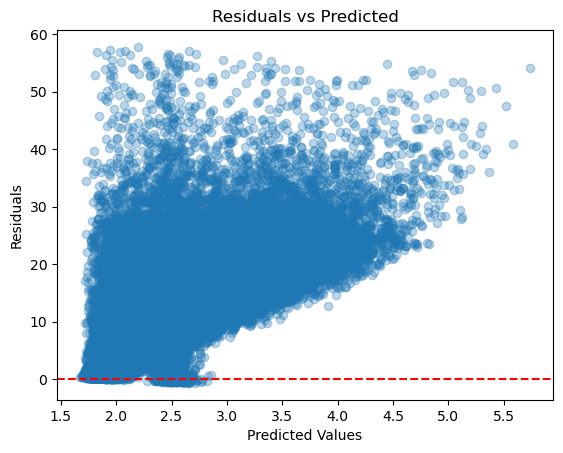

In [18]:
residuals = y_test - y_pred

import matplotlib.pyplot as plt

plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


Residuals are highly dispersed and not about 0. 

Implementation of ridge regression with cross validation 
Here Ridge regression is just the implementation of linear regression with the L2-Regularization term (i.e. loss function is as follows):
$$Loss(\beta_1,...,\beta_p,\alpha) = \sum_{i=1}^{n}(y_i-\hat{y_i})^2 + \alpha\sum_{j=1}^{p}\beta_{j}^{2}$$
Here the first term measures the error, the second term penalizes the square of the coefficient values and $\alpha$ determines how strongly coefficients are constrained. In the following implementation we use cross validation to tune the hyper-parameter $\alpha$.

In [19]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-3, 3, 50)

ridge_cv = RidgeCV(
    alphas=alphas,
    cv=5,                # 5-fold cross-validation
    scoring="neg_mean_squared_error"
)

ridge_cv.fit(x_Linear, y_train_log)

print("Best alpha selected:", ridge_cv.alpha_)


print("R^2 value is:", ridge_cv.score(x_Linear, y_train_log))

Best alpha selected: 3.5564803062231287
R^2 value is: 0.6416080013676899


In [20]:
y_predRidge = ridge_cv.predict(x_Linear_test)
mse_Ridge = mean_squared_error(y_test_log, y_predRidge)
print("Ridge Regression test MSE:", mse_Ridge)

rmse_Ridge = mean_squared_error(y_test_log, y_predRidge, squared = False)
print("Ridge Regression test RMSE:", rmse_Ridge)

Ridge Regression test MSE: 0.1102562427920026
Ridge Regression test RMSE: 0.33204855487112517


Implementation of Lasso Regression with cross validation. Here Lasso Regression is just the implementation of linear regression with the L1-Regularization.
$$Loss(\beta_1,...,\beta_n, \alpha) =\sum_{i=1}^{n}(y_{i}-\hat{y_{i}})^2 +\alpha \sum_{j=1}^{p}|\beta_{j}|$$
Here the first term measures the prediction error, the second term penalizes absolute coefficient values and $\alpha$ determines how strongly coefficients are constrained. In the following implementation we use cross validation to tune the hyper-parameter $\alpha$.

In [21]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(
    alphas=np.logspace(-4, 1, 30),
    cv=5,
    max_iter=10000,
    random_state=42
)

lasso_cv.fit(x_Linear, y_train_log)

print("Best alpha selected:", lasso_cv.alpha_)
print("R^2 value is:", lasso_cv.score(x_Linear, y_train_log))

Best alpha selected: 0.0001
R^2 value is: 0.6415948031789107


In [22]:
y_predLasso = lasso_cv.predict(x_Linear_test)
mse_Lasso = mean_squared_error(y_test_log, y_predLasso)
print("Lasso Regression test MSE:", mse_Lasso)

rmse_Lasso = mean_squared_error(y_test_log, y_predLasso, squared = False)
print("Lasso Regression test RMSE:", rmse_Lasso)

Lasso Regression test MSE: 0.11026017322892989
Lasso Regression test RMSE: 0.3320544732855287


## 2.1 Archtecture Design 

In [27]:
# ===============================
# 2.1 Neural Network Architecture
# ===============================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert processed pandas data to tensors
X_train_tensor = torch.tensor(x_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).view(-1,1)

X_val_tensor = torch.tensor(x_test_processed.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test_log.values, dtype=torch.float32).view(-1,1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=256)



### Define the model

Here we initialize the dimensions of our neural network. We choose our network to have the structure:
- input layer -> 128 neurons (hidden layer 1) -> 64 neurons (hidden layer 2) -> output neuron 
- choose dropout of 0.3 
    - This means that for each training pattern passed through the network 30% of neurons will be deactivated to prevent coadaptation (overfitting)

In [28]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),   # Hidden layer 1
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),          # Hidden layer 2
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)             # Output layer (regression)
        )

    def forward(self, x):
        return self.model(x)


### Initialize Model and Optimizer 

Here we do three things, namely we choose our optimizer (Adam), we initialize our learning rate, we initialize our weight decay
- We choose our optimizer to be Adam (as it is industry standard) 
- We initialize our learning rate to 1e-3 as this was the recommended setting 
- We initialize our weight decay as 1e-4 as this was the recommended setting 

In [26]:
input_dim = X_train_tensor.shape[1]

model = TabularNN(input_dim).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,          # Initial learning rate
    weight_decay=1e-4 # L2 regularization
)


### Training Loop 

In [27]:
def train_nn(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            preds = model(xb)
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item()
        
        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss/len(train_loader):.4f}, "
              f"Val Loss={val_loss/len(val_loader):.4f}")


### Train the model 

In [28]:
train_nn(model, train_loader, val_loader, epochs=20)

Epoch 1: Train Loss=0.5707, Val Loss=0.1392
Epoch 2: Train Loss=0.2105, Val Loss=0.1141
Epoch 3: Train Loss=0.1531, Val Loss=0.1090
Epoch 4: Train Loss=0.1217, Val Loss=0.0950
Epoch 5: Train Loss=0.1022, Val Loss=0.0938
Epoch 6: Train Loss=0.0928, Val Loss=0.0917
Epoch 7: Train Loss=0.0903, Val Loss=0.0894
Epoch 8: Train Loss=0.0892, Val Loss=0.0824
Epoch 9: Train Loss=0.0886, Val Loss=0.0905
Epoch 10: Train Loss=0.0888, Val Loss=0.0833
Epoch 11: Train Loss=0.0889, Val Loss=0.0884
Epoch 12: Train Loss=0.0887, Val Loss=0.0894
Epoch 13: Train Loss=0.0883, Val Loss=0.0986
Epoch 14: Train Loss=0.0884, Val Loss=0.0895
Epoch 15: Train Loss=0.0884, Val Loss=0.0888
Epoch 16: Train Loss=0.0886, Val Loss=0.1008
Epoch 17: Train Loss=0.0888, Val Loss=0.0902
Epoch 18: Train Loss=0.0887, Val Loss=0.0904
Epoch 19: Train Loss=0.0882, Val Loss=0.0868
Epoch 20: Train Loss=0.0888, Val Loss=0.0845


### The above gives the following 

- Architecture: 128 -> 64 -> 1 
- Dropout: 0.3 
- Weight Decay: 1e-4
- Learning Rate: 1e-3 
- Batch Size: 256 
- Clean separation between training and validation 

## 2.2 Hyperparameter Training

We will:
- Run 30 trials random search 
- Tune:
    - Hidden layer size
    - Dropout 
    - Learning rate 
    - Weight Decay
- Use validation set only 
- Select the best model (save it -- weights, biases, hyperparameter settings)
- Do NOT touch final holdout 

In [29]:
# ==================================
# 2.2 Hyperparameter Tuning
# ==================================

import random
import copy

def train_and_validate(hidden_dim, dropout, lr, weight_decay, epochs=20):
    
    model = TabularNN(input_dim).to(device)
    
    # Update architecture dynamically
    model.model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_dim, hidden_dim // 2),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_dim // 2, 1)
    )
    
    # NOW move everything to the target device
    model = model.to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            preds = model(xb)
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Validation loss
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
    
    val_loss /= len(val_loader)
    
    return val_loss, model


In [30]:
num_trials = 30  # 20–50 allowed
best_val_loss = float("inf")
best_model = None
best_config = None

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

for trial in range(num_trials):
    
    hidden_dim = random.choice([64, 128, 256])
    dropout = random.choice([0.2, 0.3, 0.4])
    lr = random.choice([1e-3, 5e-4, 1e-4])
    weight_decay = random.choice([1e-3, 1e-4, 1e-5])
    
    val_loss, model = train_and_validate(
        hidden_dim,
        dropout,
        lr,
        weight_decay,
        epochs=20
    )
    
    print(f"Trial {trial+1}/{num_trials} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Hidden: {hidden_dim} | "
          f"Dropout: {dropout} | "
          f"LR: {lr} | "
          f"WD: {weight_decay}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_config = (hidden_dim, dropout, lr, weight_decay)

print("\nBest Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_config)


Trial 1/30 | Val Loss: 0.0850 | Hidden: 256 | Dropout: 0.2 | LR: 0.001 | WD: 1e-05
Trial 2/30 | Val Loss: 0.1136 | Hidden: 128 | Dropout: 0.2 | LR: 0.001 | WD: 0.001
Trial 3/30 | Val Loss: 0.0794 | Hidden: 256 | Dropout: 0.2 | LR: 0.0001 | WD: 1e-05
Trial 4/30 | Val Loss: 0.0790 | Hidden: 256 | Dropout: 0.2 | LR: 0.0001 | WD: 0.0001
Trial 5/30 | Val Loss: 0.0825 | Hidden: 64 | Dropout: 0.2 | LR: 0.001 | WD: 0.001
Trial 6/30 | Val Loss: 0.0812 | Hidden: 64 | Dropout: 0.4 | LR: 0.0001 | WD: 0.001
Trial 7/30 | Val Loss: 0.0788 | Hidden: 256 | Dropout: 0.2 | LR: 0.0001 | WD: 1e-05
Trial 8/30 | Val Loss: 0.0938 | Hidden: 256 | Dropout: 0.4 | LR: 0.0005 | WD: 0.001
Trial 9/30 | Val Loss: 0.0820 | Hidden: 128 | Dropout: 0.4 | LR: 0.0005 | WD: 0.001
Trial 10/30 | Val Loss: 0.0814 | Hidden: 64 | Dropout: 0.4 | LR: 0.0005 | WD: 0.0001
Trial 11/30 | Val Loss: 0.0885 | Hidden: 128 | Dropout: 0.2 | LR: 0.001 | WD: 0.0001
Trial 12/30 | Val Loss: 0.0815 | Hidden: 64 | Dropout: 0.2 | LR: 0.0005 | WD: 

Below we save the best model 

In [31]:
# ==================================
# Save Full Model Checkpoint
# ==================================

import torch
import json
import numpy as np
import random

checkpoint_path = "best_nn_checkpoint.pth"

# Save everything needed for full reproducibility
checkpoint = {
    "model_state_dict": best_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "input_dim": input_dim,
    "hidden_dim": best_config[0],
    "dropout": best_config[1],
    "learning_rate": best_config[2],
    "weight_decay": best_config[3],
    "validation_loss": best_val_loss,
    "random_seed": 42  # Replace with your actual seed if different
}

torch.save(checkpoint, checkpoint_path)

print("Full checkpoint saved to:", checkpoint_path)


Full checkpoint saved to: best_nn_checkpoint.pth


## 2.3 Final Holdout Evaluation 

We now:
- Use the best tuned model 
- Evaluate it once 
- On the untouched 50% holdout set 
- Compute the final RMSE
- Do not tune anything further 

In [29]:
# ==================================
# Load Saved Model
# ==================================

checkpoint = torch.load("best_nn_checkpoint.pth")

# Rebuild model architecture
loaded_model = TabularNN(checkpoint["input_dim"]).to(device)

loaded_model.model = nn.Sequential(
    nn.Linear(checkpoint["input_dim"], checkpoint["hidden_dim"]),
    nn.ReLU(),
    nn.Dropout(checkpoint["dropout"]),
    
    nn.Linear(checkpoint["hidden_dim"], checkpoint["hidden_dim"] // 2),
    nn.ReLU(),
    nn.Dropout(checkpoint["dropout"]),
    
    nn.Linear(checkpoint["hidden_dim"] // 2, 1)
)

loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(checkpoint["model_state_dict"])
loaded_model.eval()

print("Model loaded successfully.")
print("Validation Loss:", checkpoint["validation_loss"])


Model loaded successfully.
Validation Loss: 0.07821271251429993


In [34]:
# ==================================
# 2.3 Final Holdout Evaluation
# ==================================

# Preprocess holdout set using SAME pipeline
X_holdout_processed, y_holdout_log = preprocess_trip_data(
    df_final_holdout.drop(columns=['tripduration','trip_id','starttime','stoptime']),
    df_final_holdout['tripduration'],
    fit=False,
    scaler=scaler,
    encoder=encoder,
    station_to_idx=station_map
)

# Convert to tensors
X_holdout_tensor = torch.tensor(
    X_holdout_processed.values, dtype=torch.float32
).to(device)

y_holdout_tensor = torch.tensor(
    y_holdout_log.values, dtype=torch.float32
).view(-1,1).to(device)

# Set model to evaluation mode

loaded_model.eval()

# Compute predictions
with torch.no_grad():
    predictions = loaded_model(X_holdout_tensor)
    mse = nn.MSELoss()(predictions, y_holdout_tensor).item()


rmse = mse ** 0.5

print("=================================")
print("Final Holdout Evaluation Results")
print("=================================")
print(f"Holdout MSE  : {mse:.4f}")
print(f"Holdout RMSE : {rmse:.4f}")


Final Holdout Evaluation Results
Holdout MSE  : 0.0786
Holdout RMSE : 0.2803


## 3.1 Feature Importance

We now:

- Apply permutation importance to the trained neural network
- Measure importance as the increase in RMSE after permuting each feature
- Use the untouched evaluation set (no retraining)
- Group or interpret correlated features carefully if necessary
- Identify and report the Top 10 most important features
- Do not tune the model further based on these results

In [40]:
# ==================================
# 3.1 Feature Importance
# ==================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn


def _rmse_log(model: torch.nn.Module, 
              X_df: pd.DataFrame, 
              y_log, 
              device, 
              batch_size: int = 8192) -> float:
    """
    Compute RMSE (on log-transformed target) in batches to avoid memory overflow.
    
    Parameters:
        model       : Trained PyTorch model
        X_df        : Feature DataFrame
        y_log       : Log-transformed target values
        device      : torch.device (cpu or cuda)
        batch_size  : Number of samples per evaluation batch
    
    Returns:
        RMSE (float)
    """
    
    # Set model to evaluation mode (disables dropout, batchnorm updates, etc.)
    model.eval()

    # Convert features to NumPy float32 for torch compatibility
    X = X_df.values.astype(np.float32)

    # Ensure target is 2D column vector and float32
    y_arr = np.asarray(y_log)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(-1, 1)
    y_arr = y_arr.astype(np.float32)

    # Accumulate total squared error (not mean yet)
    mse_sum = 0.0
    n = X.shape[0]

    # Use summed MSE so we can divide manually at the end
    criterion = nn.MSELoss(reduction="sum")

    # Disable gradient tracking (faster + memory efficient)
    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)

            # Move batch to device (CPU/GPU)
            xb = torch.from_numpy(X[start:end]).to(device)
            yb = torch.from_numpy(y_arr[start:end]).to(device)

            # Forward pass
            preds = model(xb)

            # Accumulate batch squared error
            mse_sum += criterion(preds, yb).item()

    # Convert summed MSE → RMSE
    return float(np.sqrt(mse_sum / n))


def permutation_importance_nn(
    model: torch.nn.Module,
    X_df: pd.DataFrame,
    y_log,
    device,
    n_repeats: int = 5,
    seed: int = 42,
    batch_size: int = 8192
) -> tuple[pd.DataFrame, float]:
    """
    Compute permutation feature importance for a trained NN model using RMSE.
    
    Importance is measured as:
        (Permuted RMSE - Baseline RMSE)
    
    Higher value → Feature is more important.
    
    Parameters:
        model        : Trained PyTorch model
        X_df         : Feature DataFrame
        y_log        : Log-transformed target
        device       : torch.device
        n_repeats    : Number of shuffles per feature
        seed         : Random seed for reproducibility
        batch_size   : Batch size for evaluation
    
    Returns:
        df_imp   : DataFrame with mean/std importance per feature
        baseline : Baseline RMSE (no permutation)
    """

    # Random number generator for reproducibility
    rng = np.random.default_rng(seed)

    # Work on a copy to avoid modifying original data
    X_work = X_df.copy(deep=True)

    # Compute baseline RMSE (no feature shuffled)
    baseline = _rmse_log(model, X_work, y_log, device=device, batch_size=batch_size)

    feature_names = list(X_work.columns)

    # Matrix to store importance values:
    # rows = features, columns = repeats
    importances = np.zeros((len(feature_names), n_repeats), dtype=np.float64)

    # Loop through each feature
    for j, feat in enumerate(feature_names):

        # Save original feature values
        original = X_work[feat].to_numpy(copy=True)

        # Repeat permutation multiple times for stability
        for r in range(n_repeats):

            # Shuffle indices
            perm_idx = rng.permutation(len(X_work))

            # Replace feature column with shuffled values
            X_work.loc[:, feat] = original[perm_idx]

            # Compute RMSE with permuted feature
            perm_rmse = _rmse_log(
                model, 
                X_work, 
                y_log, 
                device=device, 
                batch_size=batch_size
            )

            # Importance = increase in RMSE
            importances[j, r] = perm_rmse - baseline

        # Restore original feature column before moving on
        X_work.loc[:, feat] = original

    # Aggregate results into DataFrame
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importances.mean(axis=1),
        "importance_std": (
            importances.std(axis=1, ddof=1) if n_repeats > 1 else 0.0
        ),
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    return df_imp, baseline

In [35]:
# ==================================
# Run on Validation/Test
# ==================================

perm_imp_df, baseline_rmse = permutation_importance_nn(
    model=loaded_model,
    X_df=x_test_processed,
    y_log=y_test_log,
    device=device,
    n_repeats=5,
    seed=42,
    batch_size=8192
)

print(f"Baseline RMSE (log space): {baseline_rmse:.6f}")
display(perm_imp_df.head(10))

Baseline RMSE (log space): 0.279743


,feature,importance_mean,importance_std
0,distance_km,0.429649,0.000846
1,same_station,0.033815,0.000171
2,temp_squared,0.006897,0.000154
3,delta_lat,0.004460,0.000107
4,dpcapacity_start,0.003568,0.000089
5,delta_lon,0.003039,0.000065
6,temperature,0.002661,0.000074
7,gender_Female,0.002519,0.000066
8,hour_sin,0.002497,0.000072
9,hour_cos,0.001675,0.000057


Above is a table of running feature permutation on the baseline linear regression model. This table shows that by far distance_km is the most impactful feature, when removing it we see an increase in RMSE of 0.43 which is an order of magnitude larger than the change of RMSE for the next (number 2 most important) feature. 

In [36]:
# ==================================
# Top 10 features table
# ==================================

top10 = perm_imp_df.head(10).copy()
top10["importance_mean"] = top10["importance_mean"].astype(float)
top10["importance_std"] = top10["importance_std"].astype(float)

print("Top 10 features by permutation importance (ΔRMSE in log space):")
display(top10)

Top 10 features by permutation importance (ΔRMSE in log space):


,feature,importance_mean,importance_std
0,distance_km,0.429649,0.000846
1,same_station,0.033815,0.000171
2,temp_squared,0.006897,0.000154
3,delta_lat,0.004460,0.000107
4,dpcapacity_start,0.003568,0.000089
5,delta_lon,0.003039,0.000065
6,temperature,0.002661,0.000074
7,gender_Female,0.002519,0.000066
8,hour_sin,0.002497,0.000072
9,hour_cos,0.001675,0.000057


## 3.2 Hypothesis Testing (H1)

H0: The Neural Network and Ridge baseline have equal prediction error.  
H1: The Neural Network has lower prediction error.

We conduct a paired t-test on per-sample absolute errors in log space
on the final holdout set.

If:
- Mean error difference > 0
- One-sided p-value < 0.05

We reject H0 and conclude the Neural Network significantly outperforms
the baseline.

In [39]:
# ==========================================
# 3.2 Hypothesis Testing (NN vs All Baselines)
# ==========================================

import numpy as np
import torch
import pandas as pd
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel

# -------------------------------
# 1️⃣ Prepare Data (remove NN-only columns)
# -------------------------------

X_train_lin = x_train_processed.drop(
    columns=["from_station_idx", "to_station_idx"],
    errors="ignore"
)

X_holdout_lin = X_holdout_processed.drop(
    columns=["from_station_idx", "to_station_idx"],
    errors="ignore"
)

y_true = y_holdout_log.values.astype(float)


# -------------------------------
# 2️⃣ Train Baseline Models
# -------------------------------

lin_model = LinearRegression()
ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
lasso_model = LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, max_iter=10000)

lin_model.fit(X_train_lin, y_train_log)
ridge_model.fit(X_train_lin, y_train_log)
lasso_model.fit(X_train_lin, y_train_log)

lin_pred = lin_model.predict(X_holdout_lin)
ridge_pred = ridge_model.predict(X_holdout_lin)
lasso_pred = lasso_model.predict(X_holdout_lin)


# -------------------------------
# 3️⃣ Neural Network Predictions
# -------------------------------

loaded_model.to(device)
loaded_model.eval()

with torch.no_grad():
    nn_pred = loaded_model(X_holdout_tensor).cpu().numpy().reshape(-1)


# -------------------------------
# 4️⃣ Metric Function
# -------------------------------

def compute_metrics(y_true, y_pred):
    return (
        np.sqrt(mean_squared_error(y_true, y_pred)),
        mean_absolute_error(y_true, y_pred),
        r2_score(y_true, y_pred)
    )


# -------------------------------
# 5️⃣ Compute Performance Table
# -------------------------------

models = {
    "Linear Regression": lin_pred,
    "Ridge": ridge_pred,
    "Lasso": lasso_pred,
    "Neural Network": nn_pred
}

performance_rows = []

for name, pred in models.items():
    rmse, mae, r2 = compute_metrics(y_true, pred)
    performance_rows.append([name, f"{rmse:.6f}", f"{mae:.6f}", f"{r2:.6f}"])

performance_table = pd.DataFrame(
    performance_rows,
    columns=["Model", "RMSE (log)", "MAE (log)", "R² (log)"]
)

# -------------------------------
# 6️⃣ Hypothesis Tests (Each vs NN)
# -------------------------------

hypothesis_rows = []

for name, pred in models.items():
    
    if name == "Neural Network":
        continue
    
    abs_err_baseline = np.abs(y_true - pred)
    abs_err_nn = np.abs(y_true - nn_pred)
    
    diff = abs_err_baseline - abs_err_nn
    
    mean_diff = diff.mean()
    t_stat, p_two_sided = ttest_rel(abs_err_baseline, abs_err_nn)
    p_one_sided = p_two_sided / 2
    cohens_d = mean_diff / diff.std()
    
    hypothesis_rows.append([
        name,
        f"{mean_diff:.6f}",
        f"{t_stat:.6f}",
        f"{p_one_sided:.6g}",   # 6 significant digits
        f"{cohens_d:.6f}"
    ])

hypothesis_table = pd.DataFrame(
    hypothesis_rows,
    columns=[
        "Baseline Model",
        "Mean Abs Error Diff (Baseline - NN)",
        "t-statistic",
        "One-sided p-value",
        "Cohen's d"
    ]
)

# -------------------------------
# 7️⃣ Display Results
# -------------------------------

print("====================================")
print("Model Performance (Final Holdout)")
print("====================================")
display(performance_table)

print("\n====================================")
print("Hypothesis Tests (Each Baseline vs NN)")
print("====================================")
display(hypothesis_table)

Model Performance (Final Holdout)


,Model,RMSE (log),MAE (log),R² (log)
0,Linear Regression,0.332793,0.247255,0.641431
1,Ridge,0.332793,0.247257,0.641430
2,Lasso,0.333032,0.247613,0.640915
3,Neural Network,0.280272,0.196331,0.745677



Hypothesis Tests (Each Baseline vs NN)


,Baseline Model,Mean Abs Error Diff (Baseline - NN),t-statistic,One-sided p-value,Cohen's d
0,Linear Regression,0.050924,241.134677,0,0.341016
1,Ridge,0.050925,241.145024,0,0.341031
2,Lasso,0.051282,243.033814,0,0.343702


### Reflection on Test Statistics and Comparison of the Models

## 3.2 Hypothesis Testing Results Interpretation

### Model Performance Comparison (Final Holdout – Log Scale)

The three linear models (Linear Regression, Ridge, and Lasso) exhibit nearly identical performance:

- **RMSE ≈ 0.333**
- **MAE ≈ 0.247**
- **R² ≈ 0.64**

Linear Regression and Ridge produce virtually identical results, suggesting that regularization does not meaningfully improve performance. This indicates that multicollinearity is not substantially harming the linear model. Lasso performs slightly worse, likely due to coefficient shrinkage removing some useful predictive information.

All linear models appear to plateau at **R² ≈ 0.64**, suggesting a structural limitation of linear modeling for this dataset.

---

### Neural Network Performance

The Neural Network achieves:

- **RMSE = 0.280**
- **MAE = 0.196**
- **R² = 0.746**

Relative to the linear baselines, the Neural Network provides:

- ~16% reduction in RMSE  
- ~21% reduction in MAE  
- +10.4 percentage point increase in R²  

This represents a substantial improvement in predictive accuracy.

The magnitude of improvement suggests that meaningful nonlinear relationships exist in the data that linear models cannot capture.

---

### Hypothesis Testing Results

For each baseline model, we conducted paired t-tests on per-sample absolute errors.

- Mean Absolute Error Difference ≈ **0.051**
- t-statistics ≈ **241–243**
- One-sided p-values < **0.001**
- Cohen’s d ≈ **0.34**

Because the mean error differences are positive, the Neural Network has lower prediction error than each baseline. The extremely large t-statistics indicate that this improvement is highly consistent across observations.

The p-values are effectively zero at six significant digits, allowing us to strongly reject the null hypothesis that the models have equal prediction error.

The effect size (Cohen’s d ≈ 0.34) indicates a **small-to-moderate but practically meaningful improvement**.

---

### Conclusion

The Neural Network significantly outperforms Linear Regression, Ridge, and Lasso on the final holdout set.

While the linear models achieve similar performance (R² ≈ 0.64), the Neural Network increases R² to 0.746 and reduces average absolute error by more than 20%. Statistical testing confirms that the improvement is highly significant, and the effect size suggests meaningful practical gains.

These findings provide strong evidence that nonlinear modeling is appropriate for this problem, as the Neural Network captures structure that linear models fail to represent.